In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.corpus import stopwords
from sklearn.metrics import classification_report, f1_score
from IPython import display

### Load the data for the first glance

In [9]:
df = pd.read_csv('./task/dataset/train.tsv', sep='\t')
df

,title,is_fake
0,Москвичу Владимиру Клутину пришёл счёт за вмеш...,1
1,Агент Кокорина назвал езду по встречке житейск...,0
2,Госдума рассмотрит возможность введения секрет...,1
3,ФАС заблокировала поставку скоростных трамваев...,0
4,Против Навального завели дело о недоносительст...,1
...,...,...
5753,Эдди Чемберс получил сотрясение мозга в бою с ...,0
5754,Правительство застроит Россию нефтепродуктопро...,0
5755,«Мне стыдно перед дедом»: новый канцлер ФРГ об...,1
5756,Туркмения в декабре начнет поставки газа в Китай,0


In [10]:
df.describe()

,is_fake
count,5758.000000
mean,0.500000
std,0.500043
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


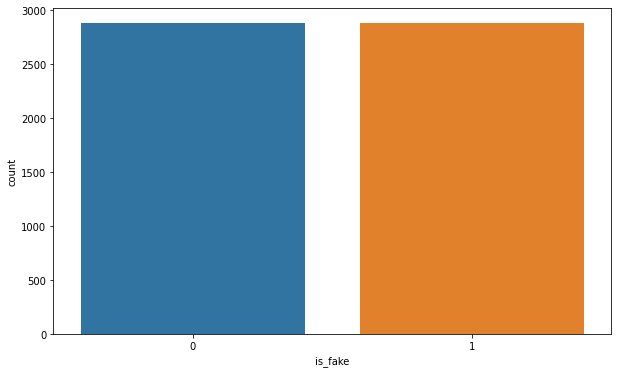

In [11]:
plt.figure(figsize=(10, 6))
sns.countplot(x=df.is_fake, data=df.is_fake);

In [12]:
df.isnull().sum()

title      0
is_fake    0
dtype: int64

### Let's remove stopwords and visualize most common words in the given corpus

In [14]:
stop_w = set(stopwords.words('russian'))

def remove_stopwords(text):
    result = []
    for _ in text.split():
        if _.strip().lower() not in stop_w:
            result.append(_.strip().lower())
    return " ".join(result)

In [15]:
df_wo_stop = df.copy()

In [16]:
df_wo_stop['title'] = df_wo_stop['title'].apply(remove_stopwords)

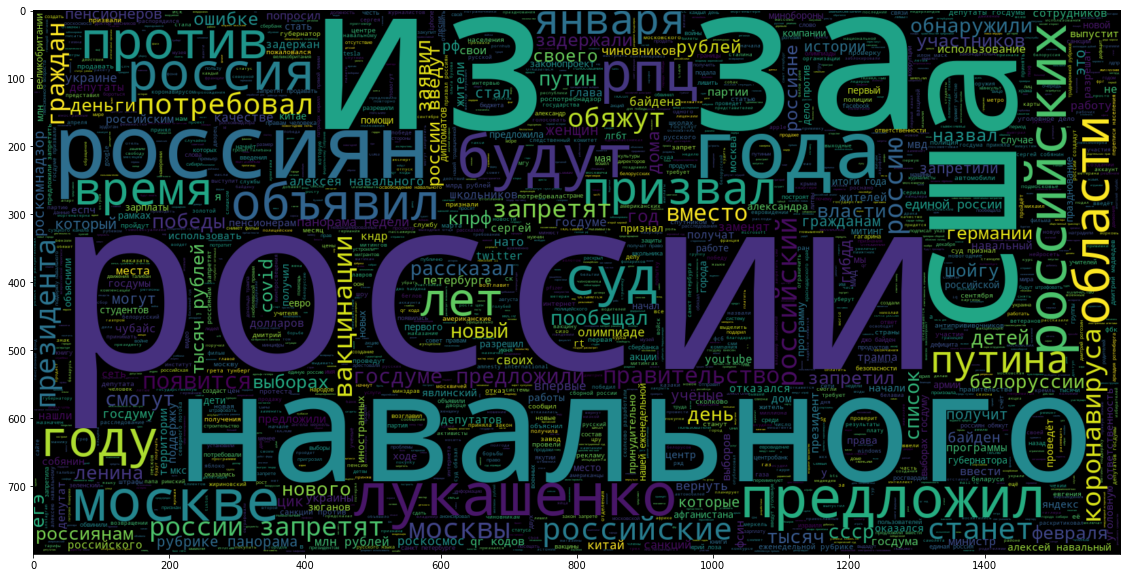

In [17]:
plt.figure(figsize=(20, 10))
word_cloud = WordCloud(max_words=2000, width=1600, height=800).generate(" ".join(df_wo_stop[df_wo_stop['is_fake'] == 1].title))
plt.imshow(word_cloud, interpolation = 'bilinear');

### Seems like news about Navalny mostly fake. Sad but true

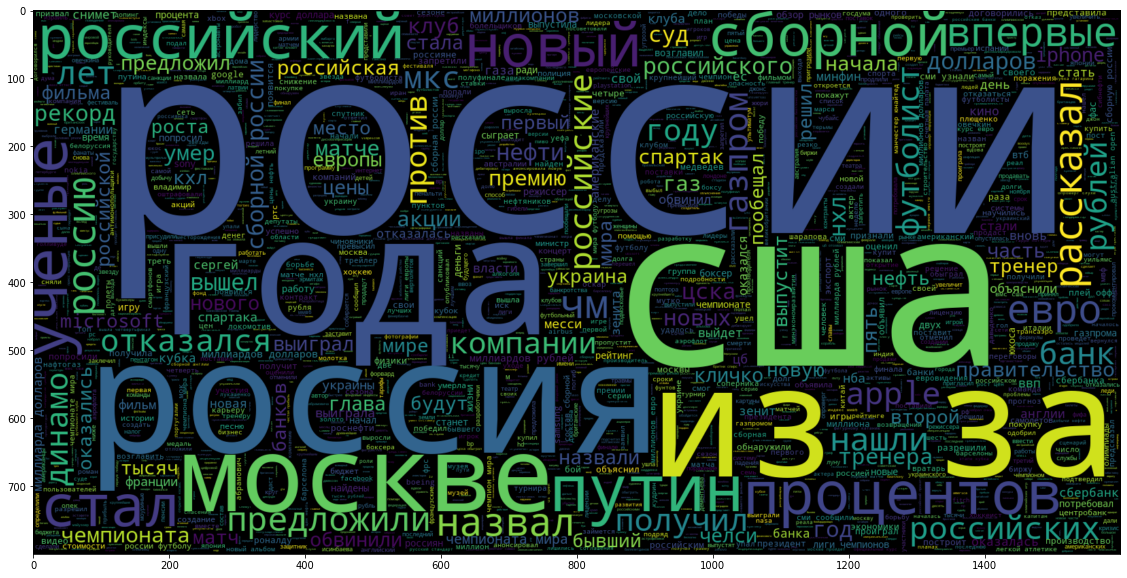

In [18]:
plt.figure(figsize=(20, 10))
word_cloud = WordCloud(max_words=2000, width=1600, height=800).generate(" ".join(df_wo_stop[df_wo_stop['is_fake'] == 0].title))
plt.imshow(word_cloud, interpolation = 'bilinear');

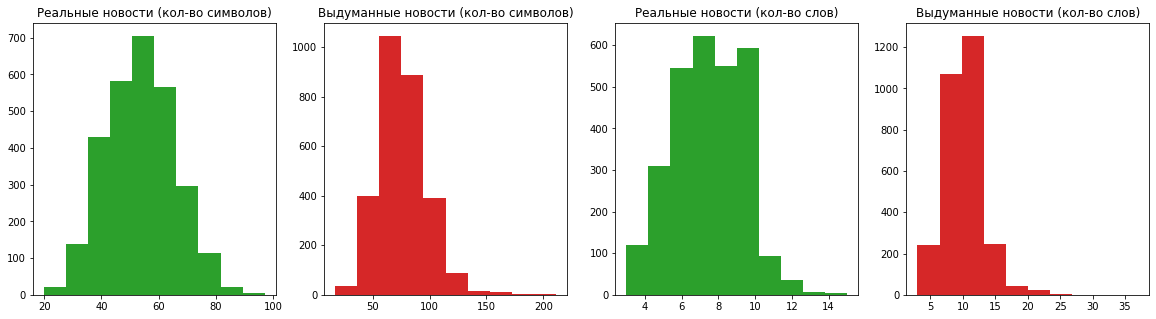

In [19]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 5))
text_length = df[df['is_fake'] == 0].title.str.len()
ax1.hist(text_length, color='tab:green')
ax1.set_title('Реальные новости (кол-во символов)')
text_length = df[df['is_fake'] == 1].title.str.len()
ax2.hist(text_length, color='tab:red')
ax2.set_title('Выдуманные новости (кол-во символов)')

words_in_title = df[df['is_fake'] == 0].title.str.split().map(lambda x: len(x))
ax3.hist(words_in_title, color='tab:green')
ax3.set_title('Реальные новости (кол-во слов)')
words_in_title = df[df['is_fake'] == 1].title.str.split().map(lambda x: len(x))
ax4.hist(words_in_title, color='tab:red')
ax4.set_title('Выдуманные новости (кол-во слов)');

### Real news data looks more realistic (lol) chars distribution close to normal

### Okay. Let's now split the data and build a baseline using Bag of Words and TfIdf

In [38]:
texts = df['title'].values
target = df['is_fake'].values

In [39]:
from sklearn.model_selection import train_test_split
texts_train, texts_test, y_train, y_test = train_test_split(texts, target, test_size=0.3, random_state=118)

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier, SGDClassifier, LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from sklearn import metrics

In [41]:
count_vect = CountVectorizer()
tfidf = TfidfVectorizer()

count_train = count_vect.fit_transform(texts_train)
count_test = count_vect.transform(texts_test)

tfidf_train = tfidf.fit_transform(texts_train)
tfidf_test = tfidf.transform(texts_test)

In [43]:
count_train.shape, count_test.shape, tfidf_train.shape, tfidf_test.shape

((4030, 14663), (1728, 14663), (4030, 14663), (1728, 14663))

In [44]:
mn_count_clf = MultinomialNB(alpha=0.1) 

In [45]:
mn_count_clf.fit(count_train, y_train)
pred = mn_count_clf.predict(count_test)
score = metrics.f1_score(y_test, pred)
print("f1_score:   %0.3f" % score)

f1_score:   0.857


In [46]:
mn_tfidf_clf = MultinomialNB(alpha=0.1) 

In [47]:
mn_tfidf_clf.fit(tfidf_train, y_train)
pred = mn_tfidf_clf.predict(tfidf_test)
score = metrics.f1_score(y_test, pred)
print("f1_score:   %0.3f" % score)

f1_score:   0.853


In [48]:
pa_tfidf_clf = PassiveAggressiveClassifier(n_iter_no_change=50)

In [49]:
pa_tfidf_clf.fit(tfidf_train, y_train)
pred = pa_tfidf_clf.predict(tfidf_test)
score = metrics.f1_score(y_test, pred)
print("f1_score:   %0.3f" % score)

f1_score:   0.855


In [50]:
svc_tfidf_clf = LinearSVC()

In [51]:
svc_tfidf_clf.fit(tfidf_train, y_train)
pred = svc_tfidf_clf.predict(tfidf_test)
score = metrics.f1_score(y_test, pred)
print("f1_score:   %0.3f" % score)

f1_score:   0.849


In [52]:
sgd_tfidf_clf = SGDClassifier()

In [53]:
sgd_tfidf_clf.fit(tfidf_train, y_train)
pred = sgd_tfidf_clf.predict(tfidf_test)
score = metrics.f1_score(y_test, pred)
print("f1_score:   %0.3f" % score)

f1_score:   0.853


In [54]:
lr_tfidf_clf = LogisticRegression()

In [55]:
lr_tfidf_clf.fit(tfidf_train, y_train)
pred = lr_tfidf_clf.predict(tfidf_test)
score = metrics.f1_score(y_test, pred)
print("f1_score:   %0.3f" % score)

f1_score:   0.826


 ### Let's plot a beatiful ROC AUC curves for our results

<Figure size 432x288 with 0 Axes>

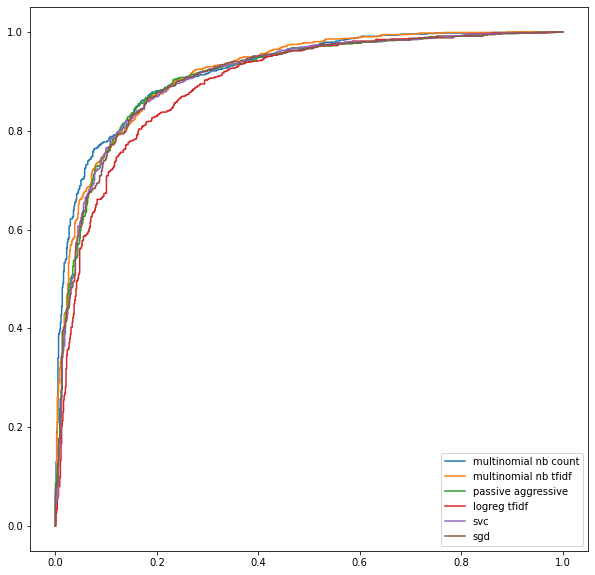

In [56]:
plt.figure(0).clf();
plt.figure(figsize=(10, 10));

for model, name in [ (mn_count_clf, 'multinomial nb count'),
                     (mn_tfidf_clf, 'multinomial nb tfidf'),
                     (pa_tfidf_clf, 'passive aggressive'),
                     (lr_tfidf_clf, 'logreg tfidf'),
                     (svc_tfidf_clf, 'svc'),
                     (sgd_tfidf_clf, 'sgd')]:
    if 'count' in name:
        pred = model.predict_proba(count_test)[:,1]
    elif 'multinomial' in name:
        pred = model.predict_proba(tfidf_test)[:,1]
    else: 
        pred = model.decision_function(tfidf_test)
    fpr, tpr, thresh = metrics.roc_curve(y_test, pred, pos_label=1)
    plt.plot(fpr,tpr,label="{}".format(name));

plt.legend(loc=0);

### Naive Bayes with bag of words gives the best result for baseline. 
### Let's check it on a few real news from panorama.wtf


In [65]:
panorama_news = np.array([
    'УАЗ готовится вывести на рынок новый антикризисный микроавтобус без электроники и с полным приводом',
    'Власти Литвы призывают горожан своевременно сбивать сосульки в своих квартирах ',
    'Илон Маск рекомендовал NASA покупать космические технологии за рубли '
])

count_test = count_vect.transform(panorama_news)

In [67]:
mn_count_clf.predict(count_test)

array([0, 1, 1])

### All news were fake and as we can see our model can't handle the first one. Honestly when I saw this article I thought it's real.
### Anyway the last two news were classified as fake. That's great!
### For further experiments I'm going to try word2vec, CNN and LSTM.
### Stay tuned!